In [1]:
import os, gc
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers

2023-06-11 01:01:52.827957: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
import tensorflow as tf
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
from training_data import TrainingData, Normalizer
norm = Normalizer(range=[[-100, 0, 0], [100, 500, 500]])
all_data = TrainingData('training_data/d0.00', output_norm=norm.normalize)
training_data, test_data = all_data.split([0.995, 0.005])
len(training_data)

199000

[0.    0.24  0.024]


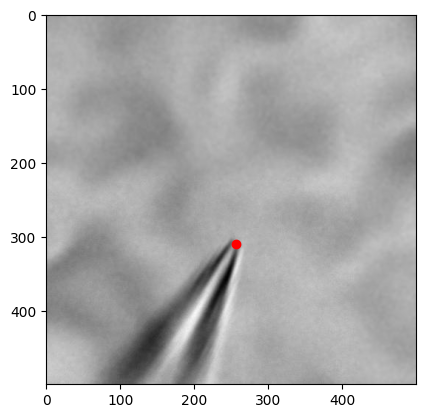

In [4]:
fig, ax = plt.subplots()
example = 2
ax.imshow(training_data[example][0])
pos = norm.denormalize(training_data[example][1])
ax.scatter(pos[2], pos[1], color='red')
print(training_data[example][1])

In [5]:
batch_size = 64
input_shape = training_data[0][0].shape


In [6]:
def below_threshold(y_true, y_pred, threshold=0.1):
    kb = keras.backend
    diff = kb.abs(y_true - y_pred)    
    return kb.mean(kb.cast(kb.all(diff < threshold, axis=-1), 'float32'))
    
test_images, test_pos = test_data[:256]

class PeriodicValidation(keras.callbacks.Callback):
    def __init__(self, n_iter):
        self._n_iter = n_iter
        self._current_iter = 0
        keras.callbacks.Callback.__init__(self)
        
    def on_train_batch_end(self, batch, logs=None):
        if self._current_iter % self._n_iter == 0:
            pred_pos = model.predict(test_images, verbose=0)
            mse = np.mean(np.square(test_pos - pred_pos))
            bt = below_threshold(test_pos, pred_pos)
            print(f"\nIter {self._current_iter} validation:  MSE: {mse}  below threshold: {bt}")
            gc.collect() 
            keras.backend.clear_session()
            
        self._current_iter += 1
        
#         print(model.evaluate(test_images, test_pos))
        

In [7]:
# Load a pre-trained ResNet model, without the top (classification) layer
# base_model = keras.applications.ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)
base_model = keras.applications.ResNet101V2(weights='imagenet', include_top=False, input_shape=input_shape)
# base_model = keras.applications.VGG16(weights='imagenet', include_top=False, input_shape=input_shape)
# base_model = keras.applications.VGG19(weights='imagenet', include_top=False, input_shape=input_shape)
base_model.trainable = False

model = keras.models.Sequential([
    keras.Input(shape=input_shape),
    base_model,
#     keras.layers.Flatten(),
    keras.layers.GlobalAveragePooling2D(),
#     keras.layers.Dense(512, activation='relu'),
#     keras.layers.Dense(256, activation='relu'),
#     keras.layers.Dense(256, activation='relu'),
    keras.layers.Dense(3),
])

2023-06-09 08:00:46.467953: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1635] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22249 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:65:00.0, compute capability: 8.6


In [8]:
for i,layer in enumerate(base_model.layers):
#     layer.trainable = False
#     layer.trainable = i > len(base_model.layers) * 0.9
    layer.trainable = i > len(base_model.layers) * 0.75
#     layer.trainable = i > len(base_model.layers) * 0.5
#     layer.trainable = i > len(base_model.layers) * 0.25
#     layer.trainable = True

model.compile(
    optimizer=keras.optimizers.Adam(), 
    loss='mse',
    metrics=[below_threshold],
)

model.fit(
    training_data.generator(batch_size=batch_size), 
    steps_per_epoch=len(training_data)//batch_size, 
    epochs=20, 
    batch_size=batch_size,
    callbacks=[PeriodicValidation(50)],
)

Epoch 1/20


2023-06-09 08:00:50.009664: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2023-06-09 08:00:55.369778: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8600
2023-06-09 08:00:56.452446: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:637] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-06-09 08:00:57.512972: I tensorflow/compiler/xla/service/service.cc:169] XLA service 0x22203840 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-06-09 08:00:57.513008: I tensorflow/compiler/xla/service/service.cc:177]   StreamExecutor device (0): NVIDIA GeForce RTX 3090, Compute Capability 8.6
2023-06-09 08:00:57.517317: I


Iter 0 validation:  MSE: 0.7863061144240867  below threshold: 0.0
  50/3109 [..............................] - ETA: 19:25 - loss: 0.2366 - below_threshold: 0.0137
Iter 50 validation:  MSE: 0.43847519657767914  below threshold: 0.0
 100/3109 [..............................] - ETA: 20:52 - loss: 0.1895 - below_threshold: 0.0214
Iter 100 validation:  MSE: 0.1972266372009689  below threshold: 0.0078125
 150/3109 [>.............................] - ETA: 21:03 - loss: 0.1684 - below_threshold: 0.0258
Iter 150 validation:  MSE: 0.11993884248338053  below threshold: 0.03125
 200/3109 [>.............................] - ETA: 20:56 - loss: 0.1541 - below_threshold: 0.0306
Iter 200 validation:  MSE: 0.11793870103926034  below threshold: 0.046875
 250/3109 [=>............................] - ETA: 20:44 - loss: 0.1462 - below_threshold: 0.0326
Iter 250 validation:  MSE: 0.10683746829547602  below threshold: 0.05078125
 300/3109 [=>............................] - ETA: 20:28 - loss: 0.1385 - below_thre

In [9]:
# test_images, test_pos = test_data[:256]
# test_images, test_pos = test_data[:100]

pred_pos = model.predict(test_images)

mse = np.mean(np.square(norm.denormalize(test_pos) - norm.denormalize(pred_pos)))
print(f'Test MSE (in pixels): {mse}')

mse = np.mean(np.square(test_pos - pred_pos))
print(f'Test MSE: {mse}')

bt = below_threshold(test_pos, pred_pos)
print(f'Below threshold: {bt}')
# print(model.evaluate(test_images, test_pos))


In [10]:

fig, ax = plt.subplots(5, 5, figsize=(15, 15))
for i in range(5):
    for j in range(5):
        index = i * 5 + j
        ax[i,j].imshow(test_images[index], cmap='gray')
        test = norm.denormalize(test_pos[index])
        ax[i,j].scatter(test[2], test[1], color='green')
        pred = norm.denormalize(pred_pos[index])
        ax[i,j].scatter(pred[2], pred[1], color='red')


In [ ]:
from PIL import Image
import scipy.ndimage

In [ ]:
img = np.asarray(Image.open('test_examples/patch-clamp-dic-hippocampal-mossy-cell.png')).astype(float)[..., :3]
img -= img.min()
img /= img.max()
img = scipy.ndimage.rotate(img, 60)
img = img[400:900, 270:770]
pred_pos = model.predict(img[None, ...]) * training_data.image_shape[0]

fig, ax = plt.subplots()
ax.imshow(img)
ax.scatter(pred_pos[0,2], pred_pos[0,1])

In [ ]:
pred_pos